In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize, OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    precision_recall_curve,
    recall_score,
    log_loss,
    confusion_matrix,
    classification_report,
    average_precision_score,
    auc
)
import time
import joblib
import multiprocessing
multiprocessing.set_start_method("spawn", force=True)

np.random.seed(0)

In [70]:
df = pd.read_csv("Dataset_2_DATA.csv", encoding='cp1251')[lambda df: df['DAGSOORT'] == 1]
df_d = pd.read_csv("Dataset_2_DESCRIPTION.csv", encoding='cp1251')

## Подготовка данных

### 1. Обработка пропущенных значений 

In [71]:
# Проверяем датафрейм на содержание NaN-значений
has_any_missing = df.isna().any().any()
print("Есть ли NaN в датафрейме?", has_any_missing)

# Может показаться, что пропусков нет, но если проверить столбцы на соотвествие типу object можно понять,
# что два столбца потенциально могут содержать "нетипичные" пропуски.
print(df.dtypes[df.dtypes != 'int64'])

# Проверим уникальные значения столбцов KREISDUUR и PARKEERKOSTEN
for col in df.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения в {col}:")
    print(df[col].unique())

# Бинго! Пропуски в наборе данных обозначаются одним пробелом(' ')

Есть ли NaN в датафрейме? False
KREISDUUR        object
PARKEERKOSTEN    object
dtype: object
Уникальные значения в KREISDUUR:
['11' '8' '7' '5' '4' '3' '10' '6' '2' '9' ' ' '1']
Уникальные значения в PARKEERKOSTEN:
['0' '9' '3' '11' ' ' '13' '5' '4' '14' '12' '16' '10' '7' '2' '6' '1' '8']


In [72]:
# Заменяем пропуски на NaN-значение
df = df.replace({' ': np.nan})

# Функция для замены пропусков модой (или средним) значением
def fill_with_mode(group):
    mode_vals = group.mode()
    if not mode_vals.empty:
        return group.fillna(mode_vals.iloc[0])
    return group.fillna(group.mean())

# Заменяем пропуски в найденных столбцах
cols_to_fill = ['KREISDUUR', 'PARKEERKOSTEN']
for col in cols_to_fill:
    df[col] = df.groupby('PERSID')[col].transform(fill_with_mode)

### 2. Удаление дубликатов

In [73]:
df = df.drop_duplicates()
display(df) # Как можно заметить, количество строк не изменилось
print(df.info())

,HHID,PERSID,VPLID,RitID,HH_VALID,P_VALID,KHVM,WEGGEWEEST,VERTREKP,AANTVPL,...,HHAUTO_N,HHAUTO,HHBESTEL,HHHYBRID,HHMOTOR,HHBROM,HHSNOR,HHFIETS,HHVOUWFIETS,HHEBIKE
0,30055622,3005562201,13957101,1395710101,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
1,30055622,3005562201,13957102,1395710201,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
2,30055622,3005562201,13957201,1395720101,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
3,30055622,3005562201,13957202,1395720201,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
7,30356310,3035631001,17204101,1720410101,2,3,8,1,2,1,...,2,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7304,30862294,3086229401,19042102,1904210201,2,3,1,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7306,30862294,3086229401,19042103,1904210301,2,3,7,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7307,30862294,3086229401,19042104,1904210401,2,3,7,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7308,30862294,3086229401,19042201,1904220101,2,3,1,1,2,3,...,1,1,0,0,0,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 5700 entries, 0 to 7309
Data columns (total 56 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   HHID                     5700 non-null   int64 
 1   PERSID                   5700 non-null   int64 
 2   VPLID                    5700 non-null   int64 
 3   RitID                    5700 non-null   int64 
 4   HH_VALID                 5700 non-null   int64 
 5   P_VALID                  5700 non-null   int64 
 6   KHVM                     5700 non-null   int64 
 7   WEGGEWEEST               5700 non-null   int64 
 8   VERTREKP                 5700 non-null   int64 
 9   AANTVPL                  5700 non-null   int64 
 10  VPLDAGNR                 5700 non-null   int64 
 11  VERPL                    5700 non-null   int64 
 12  VERPLNR                  5700 non-null   int64 
 13  TOER                     5700 non-null   int64 
 14  TOER_TYPE                5700 non-null   int6

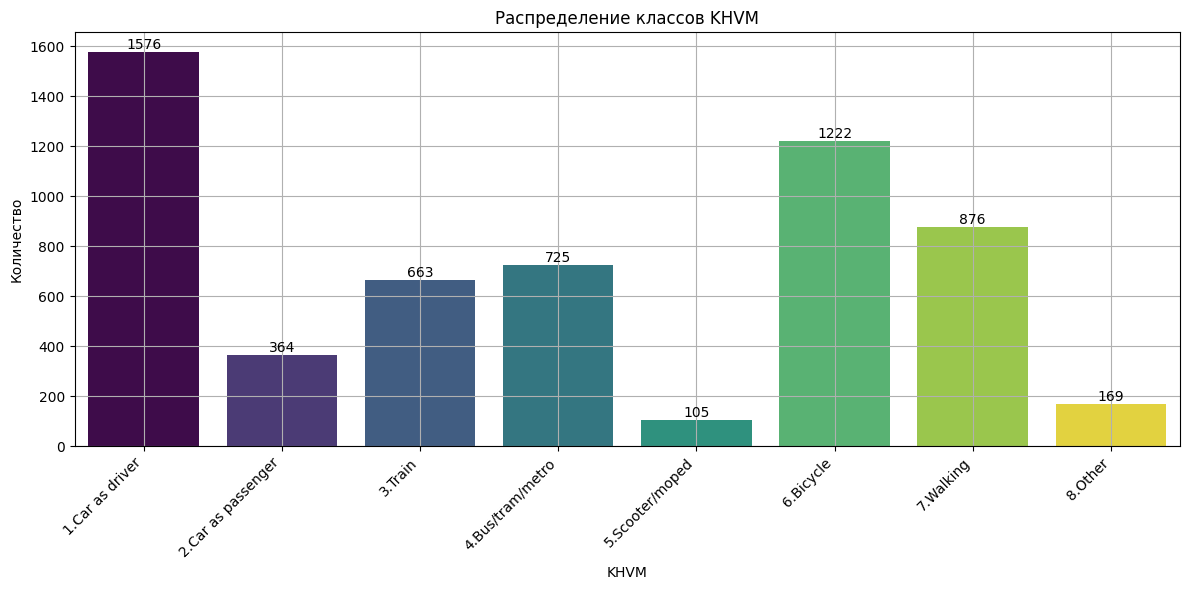

In [74]:
labels = {
    1: '1.Car as driver',
    2: '2.Car as passenger',
    3: '3.Train',
    4: '4.Bus/tram/metro',
    5: '5.Scooter/moped',
    6: '6.Bicycle',
    7: '7.Walking',
    8: '8.Other'
}


# Подсчет количества измерений для каждого класса
class_counts = df['KHVM'].value_counts().sort_index()

# Построение гистограммы распределения классов KHVM
plt.figure(figsize=(12, 6))
sns.countplot(x=df['KHVM'], hue=df['KHVM'], palette='viridis', legend=False)
plt.title('Распределение классов KHVM')
plt.ylabel('Количество')

# Установка пользовательских меток на оси X
plt.xticks(ticks=range(len(labels)), labels=[labels[i] for i in range(1, 9)], rotation=45, ha='right')

# Добавление текста с количеством измерений над каждым столбцом
for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.grid(True)
plt.tight_layout()

In [75]:
# 2. Маршрут по провинциям
df['province_route'] = df['VERTPROV'].astype(str) + '_' + df['AANKPROV'].astype(str)

df['KREISDUUR'] = pd.to_numeric(df['KREISDUUR'], errors='coerce')

# 2. Числовая длительность поездки (KREISDUUR)
duration_map = {
    1: 2.5, 2: 7.5, 3: 12.5, 4: 17.5, 5: 22.5, 6: 27.5, 
    7: 37.5, 8: 52.5, 9: 75, 10: 105, 11: 120
}
df['travel_duration'] = df['KREISDUUR'].map(duration_map)

display(df)

,HHID,PERSID,VPLID,RitID,HH_VALID,P_VALID,KHVM,WEGGEWEEST,VERTREKP,AANTVPL,...,HHBESTEL,HHHYBRID,HHMOTOR,HHBROM,HHSNOR,HHFIETS,HHVOUWFIETS,HHEBIKE,province_route,travel_duration
0,30055622,3005562201,13957101,1395710101,2,3,2,1,2,2,...,0,0,1,0,0,1,0,1,0_0,120.0
1,30055622,3005562201,13957102,1395710201,2,3,2,1,2,2,...,0,0,1,0,0,1,0,1,0_0,52.5
2,30055622,3005562201,13957201,1395720101,2,3,1,1,2,4,...,0,0,1,0,0,1,0,1,0_0,37.5
3,30055622,3005562201,13957202,1395720201,2,3,1,1,2,4,...,0,0,1,0,0,1,0,1,0_0,22.5
7,30356310,3035631001,17204101,1720410101,2,3,8,1,2,1,...,0,0,0,0,0,0,0,1,0_0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7304,30862294,3086229401,19042102,1904210201,2,3,1,1,2,5,...,0,0,0,0,0,1,0,0,27_20,105.0
7306,30862294,3086229401,19042103,1904210301,2,3,7,1,2,5,...,0,0,0,0,0,1,0,0,20_20,7.5
7307,30862294,3086229401,19042104,1904210401,2,3,7,1,2,5,...,0,0,0,0,0,1,0,0,20_20,7.5
7308,30862294,3086229401,19042201,1904220101,2,3,1,1,2,3,...,0,0,0,0,0,1,0,0,22_20,27.5


### 3. Приведение типов данных

In [76]:
# Для качественной работы LightAutoML нужно перевести int64-столбцы к category
# Получение признаков и их типов
var_types = df_d[['Variable', 'Measurement_level']].drop_duplicates()

# Список новых фич
new_features = ['province_route']

# Получение признаков и их типов из метаданных
var_types = df_d[['Variable', 'Measurement_level']].drop_duplicates()

# Добавим новые фичи как Nominal в var_types
new_features_df = pd.DataFrame({
    'Variable': new_features,
    'Measurement_level': 'Nominal'
})
var_types = pd.concat([var_types, new_features_df], ignore_index=True).drop_duplicates(subset='Variable')

# Сопоставим с колонками датасета
matched_columns = pd.DataFrame(df.columns, columns=['Variable'])
merged = matched_columns.merge(var_types, on='Variable', how='left')

# Делаем списки переменных
nominal_cols = list(merged[merged['Measurement_level'] == 'Nominal']['Variable'])
ordinal_cols = list(merged[merged['Measurement_level'] == 'Ordinal']['Variable'])
scale_cols = list(merged[merged['Measurement_level'] == 'Scale']['Variable'])

# Удаление идентификаторов
id_cols = ['HHID', 'PERSID', 'VPLID', 'RitID']
df = df.drop(columns=id_cols, errors='ignore')

# Приведение типов к category для Nominal и Ordinal
for col in nominal_cols + ordinal_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Проверка типов
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5700 entries, 0 to 7309
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   HH_VALID                 5700 non-null   category
 1   P_VALID                  5700 non-null   category
 2   KHVM                     5700 non-null   category
 3   WEGGEWEEST               5700 non-null   category
 4   VERTREKP                 5700 non-null   category
 5   AANTVPL                  5700 non-null   category
 6   VPLDAGNR                 5700 non-null   category
 7   VERPL                    5700 non-null   category
 8   VERPLNR                  5700 non-null   category
 9   TOER                     5700 non-null   category
 10  TOER_TYPE                5700 non-null   category
 11  AANTRIT                  5700 non-null   category
 12  KMOTIEF                  5700 non-null   category
 13  VERTPROV                 5700 non-null   category
 14  AANKPROV     

#### **Целевая переменная (таргет):**
**`KHVM`** — класс основного вида транспорта для поездки. 

Категории:
1. Car as driver (Водитель автомобиля)
2. Car as passenger (Пассажир автомобиля)
3. Train (Поезд)
4. Bus/tram/metro (Автобус/трамвай/метро)
5. Scooter/moped (Скутер/мопед)
6. Bicycle (Велосипед)
7. Walking (Пешком)
8. Other (Другое).

#### 1. **Демографические и домохозяйственные данные:**
- **`HHSAM`** — состав домохозяйства (например, наличие детей может влиять на выбор транспорта).
- **`HHBRUTOINK2_w5`** — доход домохозяйства (высокий доход может коррелировать с использованием автомобиля).
- **`HHAUTO`, `HHBESTEL`, `HHHYBRID`, `HHMOTOR`, `HHBROM`, `HHSNOR`, `HHFIETS`, `HHVOUWFIETS`, `HHEBIKE`** — Наличие транспортных средств.

#### 2. **Географические и инфраструктурные данные:**
- **`STED_GM`** — уровень урбанизации (влияет на доступность общественного транспорта).
- **`PROV`** — провинция (региональные различия в транспортных привычках).
- **`vlokatie_station`** — расстояние до ближайшей ж/д станции.
- **`vlokatie_bushalte4xpu`** — расстояние до часто ходящего автобуса.

#### 3. **Характеристики поездки:**
- **`KAFSTV`** — класс расстояния поездки (короткие поездки чаще на велосипеде/пешком).
- **`KVERTTIJD`** — время начала поездки (пиковые часы могут влиять на выбор транспорта).
- **`DOEL`** — цель поездки (например, работа, шопинг).
- **`MOTIEF`** — мотив поездки (деловой, leisure и т.д.).
- **`TOER`** — является ли поездка круговой (может влиять на выбор транспорта).

#### 4. **Личные предпочтения и отношение к транспорту:**
- **`OORDEEL_AUTO`** — Оценка автомобиля.  
- **`OORDEEL_TREIN`** — Оценка поезда.  
- **`OORDEEL_BTM`** — Оценка общественного транспорта.  
- **`OORDEEL_FIETS`** — Оценка велосипеда.  
- **`OORDEEL_BROMMER`** — Оценка мопеда. 
- **`OORDEEL_LOPEN`** — Оценка ходьбы.
- **`GEBRUIK_AUTO_STELLING3` / `GEBRUIK_AUTO_STELLING4`** — Восприятие авто (экономия времени, безопасность). 
- **`GEBRUIK_TREIN_STELLING3` / `GEBRUIK_TREIN_STELLING4`** — Восприятие поезда.
- **`GEBRUIK_BTM_STELLING3` / `GEBRUIK_BTM_STELLING4`** — Восприятие общественного транспорта.
- **`GEBRUIK_FIETS_STELLING2` / `GEBRUIK_FIETS_STELLING3`** — Восприятие велосипеда.
- **`GEBRUIK_LOPEN_STELLING3` / `GEBRUIK_LOPEN_STELLING4`** — Восприятие ходьбы.

#### 5. **Данные о транспортных средствах:**
- **`ROLAUTO`** — роль в поездке (водитель/пассажир).
- **`PARKEERKOSTEN`** — стоимость парковки (может влиять на решение использовать автомобиль).

In [77]:
# Отфильтруем нужные столбцы
columns_of_interest = [
    'KHVM', 'AANTVPL', 'KAFSTV', 'KMOTIEF', 'TOER',
    'ROLAUTO', 'OORDEEL_AUTO', 'OORDEEL_TREIN', 'OORDEEL_BTM',
    'OORDEEL_FIETS', 'OORDEEL_BROMMER', 'OORDEEL_LOPEN',
    'GEBRUIK_AUTO_STELLING3', 'GEBRUIK_AUTO_STELLING4',
    'GEBRUIK_TREIN_STELLING3', 'GEBRUIK_TREIN_STELLING4',
    'GEBRUIK_BTM_STELLING3', 'GEBRUIK_BTM_STELLING4',
    'GEBRUIK_FIETS_STELLING2', 'GEBRUIK_FIETS_STELLING3',
    'GEBRUIK_LOPEN_STELLING3', 'GEBRUIK_LOPEN_STELLING4',
    'HHBRUTOINK2_w5', 'HHAUTO', 'HHPERS', 'HHBESTEL', 
    'HHHYBRID', 'HHMOTOR', 'HHBROM', 'HHSNOR',
    'HHFIETS', 'HHVOUWFIETS', 'HHEBIKE', 'province_route', 
    'travel_duration'
]

df_corr = df[columns_of_interest]
corr_matrix = df_corr.corr()


fig = px.imshow(
    corr_matrix, 
    height=1000, 
    width=1000, 
    text_auto='.2f', 
    color_continuous_scale='RdBu_r',
    zmin=-1, zmax=1
)

fig.update_layout(
    title = {'text': 'Матрица корреляций признаков, связанных с основным видом транспорта (KHVM)', 'x': 0.5},
    margin=dict(t=100, b=50, l=50, r=50),
    font=dict(size=14) 
)

fig.show()


#### Выводы:
1. `ROLAUTO` - высокая отрицательная корреляция −0.74. Звучит логично т.к. если ROLAUTO равен 1(пассажир) или 2(водитель), то значение таргета KHVM ниже - относится к классам 1 или 2, а не 3-8.
2. `KAFSTV` - средняя отрицательная корреляция -0,43. Так же объяснение лежит на поверхности: чем длиннее поездка (больше KAFSTV), тем больше людей выберут авто/поезд как вид транспорта (меньше KHVM).
3. `TOER` - умеренная положительная корреляция 0,21. Интерпретация может заключаться в том, что если маршрут круговой(прогулка, поездка на велосипеде, работа) люди предпочитают использовать KHVM с большими порядковыми числами(пешком, СИД и тд).

## 4. Разбиение на train/test выборки

Для задачи мультиклассовой классфикации таргета `KHVM` выберем стандартное деление 70% для train-выборки и 30% для test-выборки - компромисс между качественным обучением модели и надёжной валидацией её предсказательной способности.

In [78]:
target_name = 'KHVM'
y = df[target_name]
X = df.drop(columns=[target_name])


# Стратифицированное деление, чтобы сохранить баланс классов
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)

ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_resample(X_train, y_train)

print(pd.Series(y_res).value_counts())


KHVM
1    1103
2    1103
3    1103
4    1103
5    1103
6    1103
7    1103
8    1103
Name: count, dtype: int64


## AutoML (LightAutoML)

Для реализации AutoML-модели я выбрал библиотеку LAMA от братьев наших меньших из сбера.
Далее идет описание AutoML-пайплайна:

In [1]:
train_data = X_res.copy()
train_data[target_name] = y_res

categorical_columns = list(train_data.select_dtypes(include=['category']).columns)

task = Task('multiclass', metric='crossentropy')

roles = {
    'target': 'KHVM'
}

automl = TabularAutoML(
    task=task,
    timeout=1500,
    cpu_limit=6,
    memory_limit=10000,
    reader_params={
        'n_jobs': 4,
        'cv': 5
    },
    lgb_params={
        'default_params': {
            'metric': 'multi_logloss',
        }
    },
    tuning_params={
        'max_iters': 20,
    }
)

start = time.time()
oof_preds = automl.fit_predict(train_data, roles=roles, verbose=1)
print("⏱ Обучение заняло:", round(time.time() - start, 2), "секунд")

joblib.dump(automl, "automl_khvm_model.joblib")
print("✅ Модель сохранена в 'automl_khvm_model.joblib'")


NameError: name 'X_res' is not defined

Далее тестируем модель и расчитываем метрики

In [ ]:
automl = joblib.load("automl_khvm_model.joblib")
# Предсказания
X_test_clean = X_test.copy()
test_preds = automl.predict(X_test_clean)

# Получаем метки классов в правильном порядке
class_labels = np.array(test_preds.features)  # список меток классов

# Обработка предсказаний
y_proba = test_preds.data  # вероятности
y_pred_idx = y_proba.argmax(axis=1)  # индексы наиболее вероятных классов
y_pred = class_labels[y_pred_idx]    # индексы → реальные метки

# Приводим y_true к тому же типу
y_true = y_test.astype(class_labels.dtype)

# Метрики
print("\n📊 Основные метрики:")
print(f"Accuracy:      {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Macro:      {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 Weighted:   {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss:      {log_loss(y_true, y_proba, labels=class_labels):.4f}")

print("\n🧩 Матрица ошибок:")
print(confusion_matrix(y_true, y_pred, labels=class_labels))

print("\n📝 Классификационный отчёт:")
print(classification_report(y_true, y_pred, labels=class_labels))


# Модель, слава тебе господи

In [79]:
ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_resample(X_train, y_train)

# Кодирование таргета
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Категориальные признаки
categorical_columns = X_train.select_dtypes(include=["category"]).columns.tolist()

# Подготовка данных для моделей, которые не поддерживают категориальные признаки напрямую
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

for col in categorical_columns:
    le_col = LabelEncoder()
    unique_values = np.unique(
        np.concatenate([X_train[col].astype(str), X_test[col].astype(str)])
    )
    le_col.fit(unique_values)
    X_train_rf[col] = le_col.transform(X_train[col].astype(str))
    X_test_rf[col] = le_col.transform(X_test[col].astype(str))

# Преобразование категориальных столбцов в строки для CatBoost
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
for col in categorical_columns:
    X_train_cat[col] = X_train_cat[col].astype(str)
    X_test_cat[col] = X_test_cat[col].astype(str)

In [ ]:
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    early_stopping_rounds=50,
    eval_metric='MultiClass',
    loss_function='MultiClass',
    task_type='CPU',
    cat_features=categorical_columns,
    verbose=100
)
xgboost_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='multi:softprob',
    eval_metric='mlogloss',
    tree_method='hist',
    enable_categorical=True
)
lightgbm_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.2,
    class_weight='balanced',
    max_bin=200,
    device='cpu',
    num_threads=7
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

models = [catboost_model, xgboost_model, lightgbm_model, rf_model]

# Кросс-валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_classes = len(np.unique(y_train_encoded))
train_meta = np.zeros((X_train.shape[0], 4 * n_classes))
test_meta = np.zeros((X_test.shape[0], 4 * n_classes, 5))

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_encoded)):
    print(f"Fold {fold+1}")
    X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
    X_tr_rf, X_val_rf = X_train_rf.iloc[train_idx], X_train_rf.iloc[val_idx]
    y_tr, y_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

    for i, model in enumerate(models):
        model_name = type(model).__name__
        print(f"  Training model: {model_name}")

        if isinstance(model, CatBoostClassifier):
            train_pool = Pool(X_tr_raw, y_tr, cat_features=categorical_columns)
            val_pool = Pool(X_val_raw, y_val, cat_features=categorical_columns)
            model.fit(train_pool, eval_set=val_pool)
            train_meta[val_idx, i*n_classes:(i+1)*n_classes] = model.predict_proba(X_val_raw)
            test_meta[:, i*n_classes:(i+1)*n_classes, fold] = model.predict_proba(X_test)

        elif isinstance(model, RandomForestClassifier):
            model.fit(X_tr_rf, y_tr)
            train_meta[val_idx, i*n_classes:(i+1)*n_classes] = model.predict_proba(X_val_rf)
            test_meta[:, i*n_classes:(i+1)*n_classes, fold] = model.predict_proba(X_test_rf)

        else:  # XGBoost и LightGBM
            model.fit(X_tr_rf, y_tr)
            train_meta[val_idx, i*n_classes:(i+1)*n_classes] = model.predict_proba(X_val_rf)
            test_meta[:, i*n_classes:(i+1)*n_classes, fold] = model.predict_proba(X_test_rf)

# Усреднение по фолдам
test_meta = test_meta.mean(axis=2)

# Сохранение моделей и мета-признаков
for i, model in enumerate(models):
    joblib.dump(model, f'base_model_{i}.pkl')

np.save('train_meta.npy', train_meta)
np.save('test_meta.npy', test_meta)
np.save('y_train_encoded.npy', y_train_encoded)


Fold 1
  Training model: CatBoostClassifier
0:	learn: 1.8928055	test: 1.8913914	best: 1.8913914 (0)	total: 114ms	remaining: 1m 53s
100:	learn: 0.3729120	test: 0.3742719	best: 0.3742719 (100)	total: 23.4s	remaining: 3m 28s
200:	learn: 0.2729220	test: 0.2986104	best: 0.2986104 (200)	total: 48.6s	remaining: 3m 13s
300:	learn: 0.2217791	test: 0.2627382	best: 0.2627382 (300)	total: 1m 15s	remaining: 2m 54s
400:	learn: 0.1915982	test: 0.2435222	best: 0.2435222 (400)	total: 1m 42s	remaining: 2m 33s
500:	learn: 0.1675330	test: 0.2274426	best: 0.2274426 (500)	total: 2m 12s	remaining: 2m 11s
600:	learn: 0.1473970	test: 0.2165136	best: 0.2164912 (597)	total: 2m 44s	remaining: 1m 49s


In [80]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()
X_train_enc[categorical_columns] = encoder.fit_transform(X_train[categorical_columns])
X_test_enc[categorical_columns] = encoder.transform(X_test[categorical_columns])

X_train_sets = [
    X_train,        # CatBoost
    X_train,        # XGBoost
    X_train_enc,    # LightGBM
    X_train_enc     # RandomForest
]
X_test_sets = [
    X_test,         # CatBoost
    X_test,         # XGBoost
    X_test_enc,     # LightGBM
    X_test_enc      # RandomForest
]


models = [joblib.load(f'base_model_{i}.pkl') for i in range(4)]
n_classes = 8


def generate_meta_features(models, X_train_sets, X_test_sets, y_train_encoded, n_classes=8, n_folds=5):
    n_models = len(models)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    train_meta = np.zeros((X_train_sets[0].shape[0], n_models * n_classes))
    test_meta_folds = np.zeros((X_test_sets[0].shape[0], n_models * n_classes, n_folds))

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_sets[0], y_train_encoded)):
        for i, model in enumerate(models):
            X_val = X_train_sets[i].iloc[val_idx]
            test_pred = model.predict_proba(X_test_sets[i])
            val_pred = model.predict_proba(X_val)

            train_meta[val_idx, i * n_classes:(i + 1) * n_classes] = val_pred
            test_meta_folds[:, i * n_classes:(i + 1) * n_classes, fold] = test_pred

    test_meta = test_meta_folds.mean(axis=2)
    return train_meta, test_meta

### Генерация мета-признаков

In [81]:
train_meta, test_meta = generate_meta_features(
    models=models,
    X_train_sets=X_train_sets,
    X_test_sets=X_test_sets,
    y_train_encoded=y_train_encoded,
    n_classes=n_classes
)

### Расчет метрик по фолдам

In [82]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X_train_sets[0], y_train_encoded)):
    print(f"\nFold {fold + 1}")
    for i, model_name in enumerate(['CatBoost', 'XGBoost', 'LightGBM', 'RandomForest']):
        y_pred = train_meta[val_idx, i*n_classes:(i+1)*n_classes]
        y_pred_sum = y_pred.sum(axis=1, keepdims=True)
        y_pred_sum[y_pred_sum == 0] = 1e-10
        y_pred = y_pred / y_pred_sum
        log_loss_score = log_loss(y_train_encoded[val_idx], y_pred, labels=range(n_classes))
        accuracy = accuracy_score(y_train_encoded[val_idx], y_pred.argmax(axis=1))
        print(f"{model_name} Log Loss: {log_loss_score:.4f}")
        print(f"{model_name} Accuracy: {accuracy:.4f}")


Fold 1
CatBoost Log Loss: 0.1794
CatBoost Accuracy: 0.9449
XGBoost Log Loss: 0.4150
XGBoost Accuracy: 0.8496
LightGBM Log Loss: 0.4092
LightGBM Accuracy: 0.8321
RandomForest Log Loss: 0.5002
RandomForest Accuracy: 0.9261

Fold 2
CatBoost Log Loss: 0.1517
CatBoost Accuracy: 0.9599
XGBoost Log Loss: 0.3602
XGBoost Accuracy: 0.8622
LightGBM Log Loss: 0.3647
LightGBM Accuracy: 0.8559
RandomForest Log Loss: 0.4868
RandomForest Accuracy: 0.9411

Fold 3
CatBoost Log Loss: 0.1497
CatBoost Accuracy: 0.9486
XGBoost Log Loss: 0.3918
XGBoost Accuracy: 0.8634
LightGBM Log Loss: 0.4126
LightGBM Accuracy: 0.8371
RandomForest Log Loss: 0.4864
RandomForest Accuracy: 0.9336

Fold 4
CatBoost Log Loss: 0.1707
CatBoost Accuracy: 0.9486
XGBoost Log Loss: 0.4254
XGBoost Accuracy: 0.8484
LightGBM Log Loss: 0.4271
LightGBM Accuracy: 0.8409
RandomForest Log Loss: 0.5120
RandomForest Accuracy: 0.9286

Fold 5
CatBoost Log Loss: 0.1521
CatBoost Accuracy: 0.9499
XGBoost Log Loss: 0.3569
XGBoost Accuracy: 0.8784
Li

### Обучение мета-моделей

In [ ]:
numerical_columns = X_train.select_dtypes(
    include=["int", "float", "bool"]
).columns.tolist()
categorical_columns = X_train.select_dtypes(
    include=["object", "category"]
).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            categorical_columns,
        ),
        ("num", "passthrough", numerical_columns),
    ],
    remainder="passthrough",
)

X_train_cat = X_train_cat[X_test_cat.columns]  # Синхронизация столбцов

catboost_pipeline = Pipeline(
    [("model", catboost_model)]
)  # CatBoost работает с X_train_cat
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            categorical_columns,
        ),
        ("num", "passthrough", X_train.columns.difference(categorical_columns)),
    ],
    remainder="passthrough",
)
xgb_pipeline = Pipeline([("preprocess", preprocessor), ("model", xgboost_model)])
lgbm_pipeline = Pipeline([("preprocess", preprocessor), ("model", lightgbm_model)])
rf_pipeline = Pipeline([("preprocess", preprocessor), ("model", rf_model)])

# Стекинг
stack = StackingClassifier(
    estimators=[
        ("catboost", catboost_pipeline),
        ("xgb", xgb_pipeline),
        ("lgbm", lgbm_pipeline),
        ("rf", rf_pipeline),
    ],
    final_estimator=CatBoostClassifier(iterations=200, learning_rate=0.03, verbose=0),
    cv=3,
    stack_method="predict_proba",
)

stack.fit(X_train_cat, y_train_encoded)
joblib.dump(stack, "stacking_model.pkl")
print("Модель сохранена в 'stacking_model.pkl'")

In [66]:
# Предсказания
y_test_pred = stack.predict(X_test_cat)
y_test_pred_proba = stack.predict_proba(X_test_cat)

# Преобразуем в одномерные массивы
y_test_encoded = y_test_encoded.ravel()
y_test_pred = y_test_pred.ravel()

# Метрики
accuracy = accuracy_score(y_test_encoded, y_test_pred)
report = classification_report(y_test_encoded, y_test_pred, digits=4, output_dict=True)
macro_avg_f1 = report["macro avg"]["f1-score"]
weighted_avg_f1 = report["weighted avg"]["f1-score"]
logloss = log_loss(y_test_encoded, y_test_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Avg F1: {macro_avg_f1:.4f}")
print(f"Weighted Avg F1: {weighted_avg_f1:.4f}")
print(f"Log Loss: {logloss:.4f}")

/Users/Shared/Py-приколы/Sandbox/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/Users/Shared/Py-приколы/Sandbox/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Accuracy: 0.9684
Macro Avg F1: 0.9668
Weighted Avg F1: 0.9685
Log Loss: 0.1073


/Users/Shared/Py-приколы/Sandbox/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

